## Mount to gdrive to read data, adjacency matrix, p_link and labels. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data which are processed in preprocessing_data_7classes.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/7classes.sim/data_7classes.pt"
Data = torch.load(path)
Data

{'x': tensor([[-0.6680,  0.3545,  0.1382,  ...,  2.1196,  0.2813,  1.3384],
         [ 0.0282,  1.6481,  1.9474,  ...,  0.8241,  0.9470,  1.9798],
         [-0.4644,  0.5799,  0.0618,  ..., -0.5351, -0.2698,  0.9294],
         ...,
         [-0.2195, -0.8809,  0.0466,  ..., -0.5610,  2.1045, -0.2778],
         [-0.7321,  0.0596,  1.4736,  ...,  0.7870,  0.7216, -1.5205],
         [ 1.0196,  0.5744,  0.3943,  ...,  1.7039, -1.3692,  0.6619]]),
 'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  4,
           4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
           6,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
           9, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 16, 16,
          17, 17, 17, 18, 18, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21,
          21, 21, 22, 22, 22, 22, 23, 24, 24, 24, 24, 25, 25, 26, 26, 26, 26, 27,
          27, 27, 28, 28, 29, 29, 29, 30, 30, 3

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 70
Number of features: 500
Number of classes: 7
Number of edges: 260
Average node degree: 3.71
Number of training nodes: 21
Number of testing nodes: 39
Training node label rate: 0.30


# Read p_link from gdrive to use it as the attention.

In [ ]:
path = F"/gdrive/MyDrive/7classes.sim/p_links_7classes.pt"
p_link = torch.load(path)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

torch.Size([70, 70])
torch.float32
torch.FloatTensor


# Install torch_geometic

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 6.6 MB/s 
     |████████████████████████████████| 4.6 MB 7.0 MB/s 
     |████████████████████████████████| 280 kB 6.4 MB/s 


# Developing my own model (making our own message passing layers), which name is BGAT.

**BGATConv**
$$ X^\prime _i = \sum_{j \in N(i)\cup i} \alpha_{ij}\Theta X_j$$
In which $\alpha$s are computed via BDgraph (p_link) and $\Theta$ is learnable parameter

In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops

# Creating message passing network.

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x=x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

# Make GNN layers with our own model, BGAT. We use three BGAT conv

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 500, out_channels = 15)
        self.conv2 =  BGATConv(15, 10)
        self.conv3 =  BGATConv(10, 7)
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.torch.tanh(h)
        h = self.conv3(h, edge_index)# Final GNN embedding space.
        h = F.log_softmax(h)
        return h
        
model = Myconv()
print(model)
print(model.forward(Data["x"], Data["edge_index"]))

Myconv(
  (conv1): BGATConv(500, 15)
  (conv2): BGATConv(15, 10)
  (conv3): BGATConv(10, 7)
)
tensor([[ -1.6038,  -3.5480,  -0.7512,  -1.4632,  -4.1339,  -3.0155,  -6.3295],
        [ -1.8167,  -2.2806,  -2.1076,  -0.7447,  -3.9225,  -2.1941,  -4.8831],
        [ -1.9168,  -2.9504,  -2.5775,  -0.3901,  -5.1676,  -3.2022,  -6.6732],
        [ -1.7701,  -1.8791,  -1.9542,  -0.9096,  -3.5461,  -2.4490,  -4.0514],
        [ -3.2950,  -2.7694,  -4.2013,  -0.1424,  -8.1786,  -4.0349, -10.3955],
        [ -1.8265,  -2.6651,  -1.5127,  -1.7854,  -2.1845,  -1.6247,  -2.6327],
        [ -1.9964,  -6.3456,  -8.2527,  -0.1534, -10.2619,  -5.4350, -17.6342],
        [ -1.3819,  -2.4975,  -1.5486,  -1.5245,  -2.3928,  -2.1056,  -3.7649],
        [ -1.8369,  -5.1594,  -7.4488,  -0.1958,  -8.7107,  -4.4240, -14.7349],
        [ -1.3772,  -7.2671,  -8.1324,  -0.2954,  -9.9204,  -5.9984, -18.6348],
        [ -1.7579,  -1.9779,  -1.7986,  -1.2895,  -2.9389,  -1.7297,  -4.0152],
        [ -1.3286,  -2.845

<ipython-input-9-ab3950bbcfdf>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


# We take a look at the node embeddings produced by our GNN (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(z[:, 0], z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",7)).set(title = "Second scenario data T-SNE projection before training (BGAT)")

Here, we pass in the initial node features x and the graph connectivity information edge_index to the model, and visualize its 2-dimensional embedding.

<ipython-input-9-ab3950bbcfdf>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Embedding shape: [70, 7]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


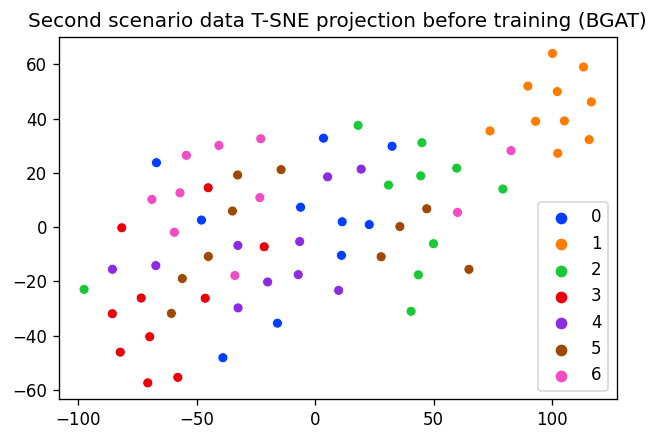

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model. 

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        #pred = out.argmax(dim=1)
        #test_correct = pred[Data["val_mask"]] == Data["y"][Data["val_mask"]]  # Check against ground-truth labels.
        #test_acc = int(test_correct.sum()) / int(Data["val_mask"].sum())  # Derive ratio of correct predictions.
        return val_loss

In [ ]:
train_loss_ = []
val_loss_ = []

for epoch in range(1, 101):

  epoch_train_loss = []
  epoch_val_loss = []
  train_loss = train(Data)
  val_loss = val(Data)






  epoch_train_loss.append(train_loss.item())
  epoch_val_loss.append(val_loss.item())




  

  val_loss_.append(sum(epoch_val_loss)/len(epoch_val_loss))
  train_loss_.append(sum(epoch_train_loss)/len(epoch_train_loss))
  print(epoch,'Train Loss: %.3f | val Loss: %.3f'%( train_loss,val_loss))

<ipython-input-9-ab3950bbcfdf>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


1 Train Loss: 2.976 | val Loss: 1.984
2 Train Loss: 1.667 | val Loss: 1.412
3 Train Loss: 1.232 | val Loss: 1.089
4 Train Loss: 0.977 | val Loss: 0.827
5 Train Loss: 0.773 | val Loss: 0.731
6 Train Loss: 0.676 | val Loss: 0.691
7 Train Loss: 0.624 | val Loss: 0.656
8 Train Loss: 0.580 | val Loss: 0.626
9 Train Loss: 0.542 | val Loss: 0.600
10 Train Loss: 0.508 | val Loss: 0.578
11 Train Loss: 0.478 | val Loss: 0.557
12 Train Loss: 0.451 | val Loss: 0.538
13 Train Loss: 0.426 | val Loss: 0.520
14 Train Loss: 0.405 | val Loss: 0.502
15 Train Loss: 0.385 | val Loss: 0.485
16 Train Loss: 0.368 | val Loss: 0.469
17 Train Loss: 0.352 | val Loss: 0.455
18 Train Loss: 0.337 | val Loss: 0.441
19 Train Loss: 0.323 | val Loss: 0.429
20 Train Loss: 0.310 | val Loss: 0.418
21 Train Loss: 0.298 | val Loss: 0.408
22 Train Loss: 0.287 | val Loss: 0.399
23 Train Loss: 0.277 | val Loss: 0.390
24 Train Loss: 0.267 | val Loss: 0.382
25 Train Loss: 0.258 | val Loss: 0.375
26 Train Loss: 0.250 | val Loss: 0

# Visualize train loss and val loss.

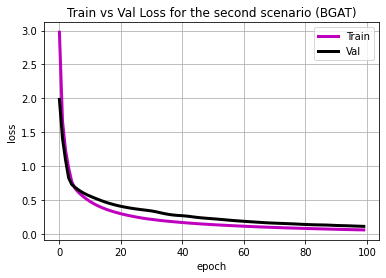

In [ ]:
plt.plot(train_loss_, "m", linewidth = 3)
plt.plot(val_loss_, "k", linewidth = 3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the second scenario (BGAT)')
plt.grid()
plt.show()

# Compute the accuracy of the model.

In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim=1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc

In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc:.2f}')

Test Accuracy: 84.62


<ipython-input-9-ab3950bbcfdf>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


# We take a look at the node embeddings produced by our GNN (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(z[:, 0], z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",7)).set(title = "Second scenario data T-SNE projection after training (BGAT)")

<ipython-input-9-ab3950bbcfdf>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


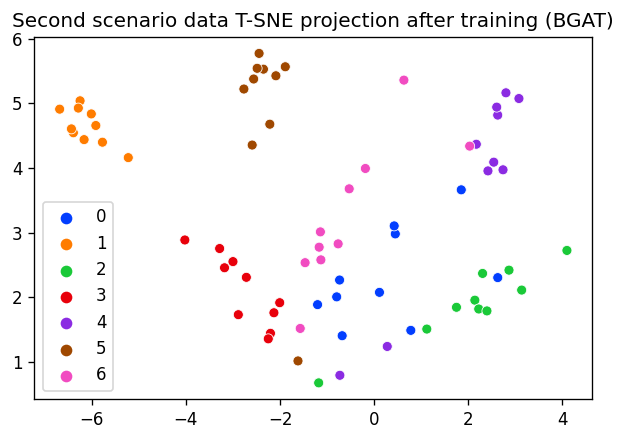

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred = out.argmax(dim=1)
pred

tensor([2, 5, 6, 6, 6, 3, 1, 4, 1, 1, 6, 4, 5, 0, 1, 5, 6, 4, 5, 3, 1, 0, 4, 6,
        2, 3, 4, 3, 4, 4, 4, 6, 1, 0, 3, 4, 2, 3, 0, 5, 2, 1, 0, 5, 2, 1, 2, 4,
        2, 6, 2, 6, 4, 1, 2, 3, 2, 4, 0, 3, 3, 1, 5, 5, 3, 2, 5, 0, 4, 0])

In [ ]:
pred = pred[Data["test_mask"]] 

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted':pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,0,2
1,5,5
2,6,6
3,3,3
4,1,1
5,4,4
6,6,6
7,0,4
8,3,3
9,5,0


<ipython-input-23-2f9b0c455fc0>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


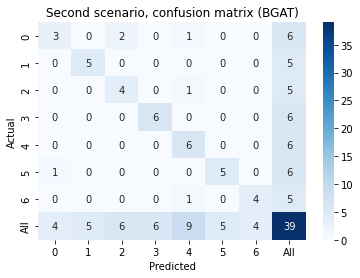

In [ ]:
confusion_matrix = pd.crosstab(data['y_Actual'], data['y_Predicted'], rownames=['Actual'], colnames = ['Predicted'], margins = True)
import seaborn as sn
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues")
ax = plt.axes()
ax.set_title('Second scenario, confusion matrix (BGAT)')
plt.show()